In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from utils import calcular_estatisticas, imprimir_estatisticas, rejeitar_hip_nula

from joblib import Parallel, delayed

import functools

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Video_games_esrb_rating.csv")
df = df.drop("title", axis=1)

X = df.drop("esrb_rating", axis=1)

y = df['esrb_rating'].values
X.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


## PCA

In [3]:
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])

<AxesSubplot:xlabel='PC 0', ylabel='PC 1'>

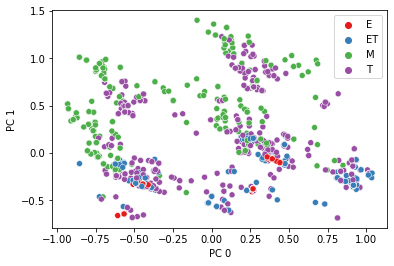

In [4]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

In [5]:
def selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, 
                             y_val, n_jobs=4, 
                             cv_folds=None, params={}):
    
    def treinar_modelo(X_treino, X_val, y_treino, y_val, params):
        clf = classificador(**params)
        clf.fit(X_treino, y_treino)
        pred = clf.predict(X_val)
        
        if len(set(y_treino)) > 2:
            return f1_score(y_val, pred, average='weighted')
        else:
            return f1_score(y_val, pred)
    
    
    if cv_folds is not None:
        #Se for pra usar validação cruzada, usar GridSearchCV
        score_fn = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        
        clf = GridSearchCV(classificador(), params, cv=cv_folds, n_jobs=n_jobs, scoring=score_fn)
        #Passar todos os dados (Treino e Validação) para realizar a seleção dos parâmetros.
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        melhor_comb = clf.best_params_
        melhor_val = clf.best_score_
        
    else:
        param_grid = list(ParameterGrid(params))
        
        f1s_val = Parallel(n_jobs=n_jobs)(delayed(treinar_modelo)
                                         (X_treino, X_val, y_treino, y_val, p) for p in param_grid)

        melhor_val = max(f1s_val)
        melhor_comb = param_grid[np.argmax(f1s_val)]
        
        clf = classificador(**melhor_comb)
        
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return clf, melhor_comb, melhor_val

In [36]:
def do_cv(classificador, X, y, cv_splits, param_cv_folds=None,
         n_jobs=2, scale=False, params={}):
    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    f1s = []
    list_confusion_matrix = []
    list_melhores_parametros = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)
        
        if scale:
            ss = StandardScaler()
            X_treino = ss.fit_transform(X_treino)
            X_teste = ss.transform(X_teste)
            X_val = ss.transform(X_val)        

        modelo, melhor_comb, _ = selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, y_val, 
                                                      n_jobs=n_jobs, cv_folds=param_cv_folds, params=params)
        pred = modelo.predict(X_teste)
        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s.append(f1)
        list_melhores_parametros.append(melhor_comb)
        list_confusion_matrix.append(confusion_matrix(y_teste, pred))
        print("----------------------------------------------------------\n")
        print("Melhor combinação: ", melhor_comb, end=' - ')
        print("Melhor score: ",f1)
        print(classification_report(y_teste, pred))

        
        pgb.update(1)
        
    pgb.close()
    
    melhor_parametro = list_melhores_parametros[np.argmax(f1s)]
    print("----------------------------------------------------------")
    print("Melhor combinação dentre todos os folds: %s" % melhor_parametro)
    print("----------------------------------------------------------")

    return f1s, list_confusion_matrix, melhor_parametro

## Árvore de Decisão

In [37]:
arvore_decisao, list_confusion_matrix, melhor_parametro = do_cv(DecisionTreeClassifier, X_pca_df.values, y, 10, 5, 4, False,  {'min_samples_leaf' : [3, 5, 10, 15, 20, 30],'min_samples_split' : [3, 5, 10, 15, 20, 30],'max_depth' : [2, 3, 4, 5]})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------

Melhor combinação:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3} - Melhor score:  0.6429391282853887
              precision    recall  f1-score   support

           E       0.91      0.69      0.78        42
          ET       0.50      0.62      0.56        40
           M       0.65      0.62      0.63        39
           T       0.61      0.62      0.61        69

    accuracy                           0.64       190
   macro avg       0.67      0.64      0.65       190
weighted avg       0.66      0.64      0.64       190

----------------------------------------------------------

Melhor combinação:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5} - Melhor score:  0.7463317097244764
              precision    recall  f1-score   support

           E       0.77      0.98      0.86        42
          ET       0.81      0.75      0.78        40
           M       0.78      0.54      0.6

In [29]:
resultados['arvore_decisao'] = arvore_decisao
imprimir_estatisticas(arvore_decisao)

Resultados: 0.70 +- 0.03, min: 0.65, max: 0.75


## Matrix de confusão

In [9]:
matrix = functools.reduce(lambda a, b: a+b, list_confusion_matrix)

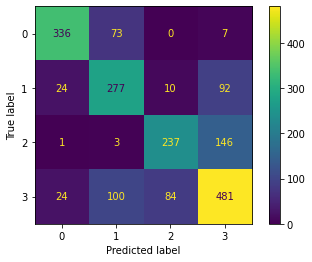

In [10]:
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [11]:
ad = DecisionTreeClassifier(**melhor_parametro)
ad.fit(X, y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5)

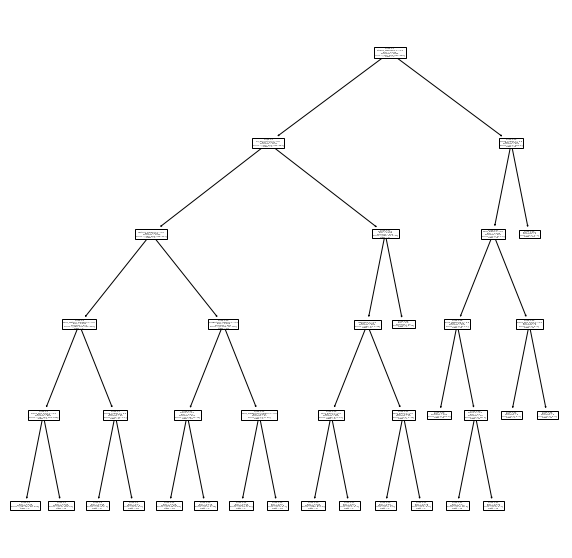

In [12]:
plt.figure(figsize=(10,10))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.savefig('dt.svg')
plt.show()

## Código da arvore de decisões

Através da imagem gerada, utilizando cada nó da árvore foi criado uma condição condizente, ao chegar nas folhas é adicionado na lista a classe predizida

In [38]:
pred = []

for linha in X.index:
    if X['strong_janguage'][linha] <= 0.5:
        if X['no_descriptors'][linha] <= 0.5:
            if X['fantasy_violence'][linha] <= 0.5:
                if X['mild_fantasy_violence'][linha] <= 0.5:
                    if X['blood_and_gore'][linha] <= 0.5:
                        pred.append('T')
                    else:
                        pred.append('M')
                else:
                    if X['crude_humor'][linha] <= 0.5:
                        pred.append('E')
                    else:
                        pred.append('ET')
            else:
                if X['suggestive_themes'][linha] <= 0.5:
                    if X['blood'][linha] <= 0.5:
                        pred.append('ET')
                    else:
                        pred.append('T')
                else:
                    if X['mild_suggestive_themes'][linha] <= 0.5:
                        pred.append('T')
                    else:
                        pred.append('ET')
        
        else:
            if X['blood'][linha] <= 0.5:
                if X['language'][linha] <= 0.5:
                    if X['mild_blood'][linha] <= 0.5:
                        pred.append('E')
                    else:
                        pred.append('T')
                else:
                    if X['mild_blood'][linha] <= 0.5:
                        pred.append('E')
                    else:
                        pred.append('T')
                    
            else:
                pred.append('T')
    else:
        if X['crude_humor'][linha] <= 0.5:
            if X['mild_blood'][linha] <= 0.5:
                if X['drug_reference'][linha] <= 0.5:
                    pred.append('M')
                else:
                    if X['blood'][linha] <= 0.5:
                        pred.append('M')
                    else:
                        pred.append('M')
            else:
                if X['blood_and_gore'][linha] <= 0.5:
                    pred.append('T')
                else:
                    pred.append('M')
                    
        else:
            pred.append('ET')

In [39]:
f1 = f1_score(y, pred, average='weighted')
f1

0.7729493120467792

## Random Forest

In [23]:
resultados = {}

In [40]:
randomForest, list_confusion_matrix, melhor_parametro = do_cv(RandomForestClassifier, X_pca_df.values, y, 10, 5, 8, False, {'n_estimators' : [100, 250, 500, 700]})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------

Melhor combinação:  {'n_estimators': 700} - Melhor score:  0.8170188859339182
              precision    recall  f1-score   support

           E       0.97      0.90      0.94        42
          ET       0.74      0.78      0.76        40
           M       0.82      0.85      0.84        39
           T       0.77      0.77      0.77        69

    accuracy                           0.82       190
   macro avg       0.83      0.82      0.82       190
weighted avg       0.82      0.82      0.82       190

----------------------------------------------------------

Melhor combinação:  {'n_estimators': 250} - Melhor score:  0.8419292618738602
              precision    recall  f1-score   support

           E       0.95      0.95      0.95        42
          ET       0.83      0.75      0.79        40
           M       0.84      0.82      0.83        39
           T       0.78      0.84      0.81        69

    accuracy     

In [41]:
resultados['randomForest'] = randomForest
imprimir_estatisticas(randomForest)

Resultados: 0.83 +- 0.03, min: 0.77, max: 0.87


In [42]:
svm, list_confusion_matrix, melhor_parametro = do_cv(SVC, X_pca_df.values, y, 10, 5, 8, False, {'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4],
                'C' : [1, 10, 100, 1000], 'kernel': ['rbf']})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------

Melhor combinação:  {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'} - Melhor score:  0.7316849465650478
              precision    recall  f1-score   support

           E       0.79      0.98      0.87        42
          ET       0.74      0.57      0.65        40
           M       0.83      0.64      0.72        39
           T       0.66      0.74      0.70        69

    accuracy                           0.74       190
   macro avg       0.76      0.73      0.74       190
weighted avg       0.74      0.74      0.73       190

----------------------------------------------------------

Melhor combinação:  {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'} - Melhor score:  0.807619537806295
              precision    recall  f1-score   support

           E       0.82      1.00      0.90        42
          ET       0.82      0.70      0.76        40
           M       0.90      0.72      0.80        39
           T       0.76

In [26]:
resultados['svm'] = svm
imprimir_estatisticas(svm)

Resultados: 0.76 +- 0.04, min: 0.70, max: 0.81


## KNN

In [43]:
knn, list_confusion_matrix, list_melhor_comb = do_cv(KNeighborsClassifier, X_pca_df.values, y, 10, 5, 2, False, {'n_neighbors' : list(range(1,30,2))})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------

Melhor combinação:  {'n_neighbors': 7} - Melhor score:  0.7666585640259175
              precision    recall  f1-score   support

           E       0.87      0.93      0.90        42
          ET       0.71      0.80      0.75        40
           M       0.72      0.72      0.72        39
           T       0.77      0.68      0.72        69

    accuracy                           0.77       190
   macro avg       0.77      0.78      0.77       190
weighted avg       0.77      0.77      0.77       190

----------------------------------------------------------

Melhor combinação:  {'n_neighbors': 1} - Melhor score:  0.7708171331292308
              precision    recall  f1-score   support

           E       0.95      0.95      0.95        42
          ET       0.74      0.88      0.80        40
           M       0.65      0.77      0.71        39
           T       0.76      0.61      0.68        69

    accuracy           

In [44]:
resultados['knn'] = knn
imprimir_estatisticas(knn)

Resultados: 0.77 +- 0.02, min: 0.74, max: 0.81


In [45]:
largura = max(map(len,resultados.keys()))+2
print(" " * largura , end="")
      
for t in resultados:
    print(t.center(largura), end='')
print()

for t in resultados:
    print(t.center(largura), end='')
    for t2 in resultados:
        d, p = rejeitar_hip_nula(resultados[t], resultados[t2], alpha=0.1)
        print(("%.05f%s" % (p, ' (*)' if d else '')).center(largura), end='')
    print()

                  randomForest        svm             knn        arvore_decisao 
  randomForest      1.00000       0.00026 (*)     0.00022 (*)     0.00000 (*)   
      svm         0.00026 (*)       1.00000         0.18716       0.00233 (*)   
      knn         0.00022 (*)       0.18716         1.00000       0.00000 (*)   
 arvore_decisao   0.00000 (*)     0.00233 (*)     0.00000 (*)       1.00000     


# Resultados

Através da tabela de resultados podemos perceber que apenas os algoritmos 